Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Deploying a MedNIST Classifier with BentoML

This notebook demos the process of packaging up a trained model using BentoML into an artifact which can be run as a local program performing inference, a web service doing the same, and a Docker containerized web service. BentoML provides various ways of deploying models with existing platforms like AWS or Azure but we'll focus on local deployment here since researchers are more likely to do this. This tutorial will train a MedNIST classifier like the [MONAI tutorial here](../../2d_classification/mednist_tutorial.ipynb) and then do the packaging as described in this [BentoML tutorial](https://github.com/bentoml/gallery/blob/master/pytorch/fashion-mnist/pytorch-fashion-mnist.ipynb).

## Setup environment

In [2]:
%pip install -q "monai-weekly[pillow, tqdm]"
%pip install -q bentoml==0.13.1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [2]:
import os
import shutil
import tempfile
import glob
import PIL.Image
import torch
import numpy as np

from ignite.engine import Events

from monai.apps import download_and_extract
from monai.config import print_config
from monai.networks.nets import DenseNet121
from monai.engines import SupervisedTrainer
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import set_determinism

set_determinism(seed=0)

print_config()

MONAI version: 1.6.dev2548
Numpy version: 1.26.4
Pytorch version: 2.8.0+cu128
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cca0c6d09175a7cf8250cf527092b671af05e303
MONAI __file__: /home/<username>/anaconda3/envs/monai/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.5
Nibabel version: 5.3.2
scikit-image version: 0.22.0
scipy version: 1.13.1
Pillow version: 11.3.0
Tensorboard version: 2.20.0
gdown version: 5.2.0
TorchVision version: 0.23.0+cu128
tqdm version: 4.67.1
lmdb version: 1.7.5
psutil version: 7.1.3
pandas version: 2.3.3
einops version: 0.8.1
transformers version: 4.40.2
mlflow version: 3.1.4
pynrrd version: 1.1.3
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://monai.readthedocs.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory
You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp6_o605sh


## Download dataset

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

If you use the MedNIST dataset, please acknowledge the source.

In [4]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:06, 10.3MB/s]                                                                                                                                   

2025-11-30 22:10:24,636 - INFO - Downloaded: /tmp/tmp6_o605sh/MedNIST.tar.gz


2025-11-30 22:10:24,723 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-11-30 22:10:24,723 - INFO - Writing into directory: /tmp/tmp6_o605sh.


In [5]:
subdirs = sorted(glob.glob(f"{data_dir}/*/"))

class_names = [os.path.basename(sd[:-1]) for sd in subdirs]
image_files = [glob.glob(f"{sb}/*") for sb in subdirs]

image_files_list = sum(image_files, [])
image_class = sum(([i] * len(f) for i, f in enumerate(image_files)), [])
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Label names: {class_names}")
print(f"Label counts: {list(map(len, image_files))}")
print(f"Total image count: {len(image_class)}")
print(f"Image dimensions: {image_width} x {image_height}")

Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]
Total image count: 58954
Image dimensions: 64 x 64


## Setup and Train

Here we'll create a transform sequence and train the network, omitting validation and testing since we know this does indeed work and it's not needed here:

In [6]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

In [7]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


# just one dataset and loader, we won't bother with validation or testing
train_ds = MedNISTDataset(image_files_list, image_class, train_transforms)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

In [8]:
device = torch.device("cuda:0")
net = DenseNet121(spatial_dims=2, in_channels=1, out_channels=len(class_names)).to(device)
loss_function = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), 1e-5)
max_epochs = 5

In [9]:
def _prepare_batch(batch, device, non_blocking):
    return tuple(b.to(device) for b in batch)


trainer = SupervisedTrainer(device, max_epochs, train_loader, net, opt, loss_function, prepare_batch=_prepare_batch)


@trainer.on(Events.EPOCH_COMPLETED)
def _print_loss(engine):
    print(f"Epoch {engine.state.epoch}/{engine.state.max_epochs} Loss: {engine.state.output[0]['loss']}")


trainer.run()

Epoch 1/5 Loss: 0.15544165670871735
Epoch 2/5 Loss: 0.09952926635742188
Epoch 3/5 Loss: 0.03600173443555832
Epoch 4/5 Loss: 0.022248581051826477
Epoch 5/5 Loss: 0.02970544993877411


The network will be saved out here as a Torchscript object but this isn't necessary as we'll see later.

In [10]:
torch.jit.script(net).save("classifier.zip")

## BentoML Setup

BentoML provides it's platform through an API to wrap service requests as method calls. This is obviously similar to how Flask works (which is one of the underlying technologies used here), but on top of this is provided various facilities for storing the network (artifacts), handling the IO component of requests, and caching data. What we need to provide is a script file to represent the services we want, BentoML will take this with the artifacts we provide and store this in a separate location which can be run locally as well as uploaded to a server (sort of like Docker registries). 

The script below will create our API which includes MONAI code. The transform sequence needs a special read Transform to turn a data stream into an image, but otherwise the code like what was used above for training. The network is stored as an artifact which in practice is the stored weights in the BentoML bundle. This is loaded at runtime automatically, but instead we could load the Torchscript model instead if we wanted to, in particular if we wanted an API that didn't rely on MONAI code. 

The script needs to be written out to a file first:

In [11]:
%%writefile mednist_classifier_bentoml.py

from typing import BinaryIO, List
import numpy as np
from PIL import Image
import torch

from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    Transform,
    ScaleIntensity,
    EnsureType,
)

import bentoml
from bentoml.frameworks.pytorch import PytorchModelArtifact
from bentoml.adapters import FileInput, JsonOutput
from bentoml.utils import cached_property

MEDNIST_CLASSES = ["AbdomenCT", "BreastMRI", "CXR", "ChestCT", "Hand", "HeadCT"]


class LoadStreamPIL(Transform):
    """Load an image file from a data stream using PIL."""

    def __init__(self, mode=None):
        self.mode = mode

    def __call__(self, stream):
        img = Image.open(stream)

        if self.mode is not None:
            img = img.convert(mode=self.mode)

        return np.array(img)


@bentoml.env(pip_packages=["torch", "numpy", "monai", "pillow"])
@bentoml.artifacts([PytorchModelArtifact("classifier")])
class MedNISTClassifier(bentoml.BentoService):
    @cached_property
    def transform(self):
        return Compose([LoadStreamPIL("L"), EnsureChannelFirst(channel_dim="no_channel"), ScaleIntensity(), EnsureType()])

    @bentoml.api(input=FileInput(), output=JsonOutput(), batch=True)
    def predict(self, file_streams: List[BinaryIO]) -> List[str]:
        img_tensors = list(map(self.transform, file_streams))
        batch = torch.stack(img_tensors).float()

        with torch.no_grad():
            outputs = self.artifacts.classifier(batch)
        _, output_classes = outputs.max(dim=1)

        return [MEDNIST_CLASSES[oc] for oc in output_classes]

Overwriting mednist_classifier_bentoml.py


Now the script is loaded and the classifier artifact is packed with the network's state. This is then saved to a repository directory on the local machine:

In [12]:
from mednist_classifier_bentoml import MedNISTClassifier  # noqa: E402

bento_svc = MedNISTClassifier()
bento_svc.pack("classifier", net.cpu().eval())

saved_path = bento_svc.save()

print(saved_path)

[2025-11-30 22:18:49,627] WARNING - Python 3.9.12 found in current environment is not officially supported by BentoML. The docker base image used is'bentoml/model-server:0.13.1' which will use conda to install Python 3.9.12 in the build process. Supported Python versions are: f3.6, 3.7, 3.8
[2025-11-30 22:18:49,628] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2025-11-30 22:18:50,510] INFO - BentoService bundle 'MedNISTClassifier:20251130221849_276B39' saved to: /home/esl/bentoml/repository/MedNISTClassifier/20251130221849_276B39
/home/esl/bentoml/repository/MedNISTClassifier/20251130221849_276B39


We can look at the contents of this repository, which includes code and setup scripts:

In [13]:
!ls -l {saved_path}

total 48
-rwxrw-r-- 1 esl esl 3170 十一 30 22:18 bentoml-init.sh
-rw-rw-r-- 1 esl esl  829 十一 30 22:18 bentoml.yml
-rwxrw-r-- 1 esl esl  841 十一 30 22:18 docker-entrypoint.sh
-rw-rw-r-- 1 esl esl 1593 十一 30 22:18 Dockerfile
-rw-rw-r-- 1 esl esl 3317 十一 30 22:18 docs.json
-rw-rw-r-- 1 esl esl   49 十一 30 22:18 environment.yml
-rw-rw-r-- 1 esl esl   72 十一 30 22:18 MANIFEST.in
drwxrwxr-x 4 esl esl 4096 十一 30 22:18 MedNISTClassifier
-rw-rw-r-- 1 esl esl    6 十一 30 22:18 python_version
-rw-rw-r-- 1 esl esl  298 十一 30 22:18 README.md
-rw-rw-r-- 1 esl esl   70 十一 30 22:18 requirements.txt
-rw-rw-r-- 1 esl esl 1691 十一 30 22:18 setup.py


This repository can be run like a stored program where we invoke it by name and the API name ("predict") we want to use and provide the inputs as a file:

In [14]:
!bentoml run MedNISTClassifier:latest predict --input-file {image_files[0][0]}

[2025-11-30 22:18:55,565] INFO - Getting latest version MedNISTClassifier:20251130221849_276B39
[2025-11-30 22:18:59,557] WARNING - Python 3.9.12 found in current environment is not officially supported by BentoML. The docker base image used is'bentoml/model-server:0.13.1' which will use conda to install Python 3.9.12 in the build process. Supported Python versions are: f3.6, 3.7, 3.8
[2025-11-30 22:18:59,611] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2025-11-30 22:18:59,632] INFO - {'service_name': 'MedNISTClassifier', 'service_version': '20251130221849_276B39', 'api': 'predict', 'task': {'data': {'uri': 'file:///tmp/tmp6_o605sh/MedNIST/AbdomenCT/008691.jpeg', 'name': '008691.jpeg'}, 'task_

The service can also be run off of a Flask web server. The following script starts the service, waits for it to get going, uses curl to send the test file as a POST request to get a prediction, then kill the server:

In [15]:
%%bash -s {image_files[0][0]}
# 取得測試圖片路徑
test_file=$1
echo "測試圖片: $test_file"

# 1. 啟動 BentoML Server，改用 Port 3000
# 使用 --port=3000 避開你的 8000
echo "正在啟動 Server (Port 3000)..."
bentoml serve --port=3000 MedNISTClassifier:latest &> server_log.txt &

# 記錄 Server 的 Process ID (PID) 以便稍後關閉
lastpid=$!

# 2. 等待 Server 啟動 (給它 10-15 秒，避免太快發送請求)
sleep 15

# 3. 發送測試請求 (curl)
# 注意：網址也要改成 3000
echo "發送預測請求..."
result=$(curl -s -X POST "http://127.0.0.1:3000/predict" -F image=@$test_file)

# 4. 關閉 Server
kill $lastpid
echo "Server 已關閉。"

# 5. 顯示結果
echo "--------------------------------"
echo "Prediction: $result"
echo "--------------------------------"

# 如果結果是空的，印出 Server log 幫助除錯
if [ -z "$result" ]; then
    echo "錯誤：沒有收到預測結果，Server 可能啟動失敗。Log 如下："
    cat server_log.txt
fi

測試圖片: /tmp/tmp6_o605sh/MedNIST/AbdomenCT/008691.jpeg
正在啟動 Server (Port 3000)...
發送預測請求...
Server 已關閉。
--------------------------------
Prediction: An error has occurred in BentoML user code when handling this request, find the error details in server logs
--------------------------------


The service can be packaged as a Docker container to be started elsewhere as a server:

In [16]:
!bentoml containerize MedNISTClassifier:latest -t mednist-classifier:latest

[2025-11-30 22:22:21,395] INFO - Getting latest version MedNISTClassifier:20251130221849_276B39
Found Bento: /home/esl/bentoml/repository/MedNISTClassifier/20251130221849_276B39
Containerizing MedNISTClassifier:20251130221849_276B39 with local YataiService and docker daemon from local environment-[2025-11-30 22:22:21,418] ERROR - RPC ERROR ContainerizeBento: Docker is required for this deployment. Please visit www.docker.com for instructions
Error: bentoml-cli containerize failed: Failed to containerize MedNISTClassifier:20251130221849_276B39 - INTERNAL:Docker is required for this deployment. Please visit www.docker.com for instructions


In [17]:
!docker image ls

REPOSITORY        TAG        IMAGE ID       CREATED         SIZE
tag-twin-api      latest     1d0b67c5072e   2 weeks ago     1.12GB
redis             7-alpine   13105d2858de   3 weeks ago     41.4MB
postgis/postgis   16-3.4     06287eb8e12c   13 months ago   609MB


[2025-11-30 22:22:24,890] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService


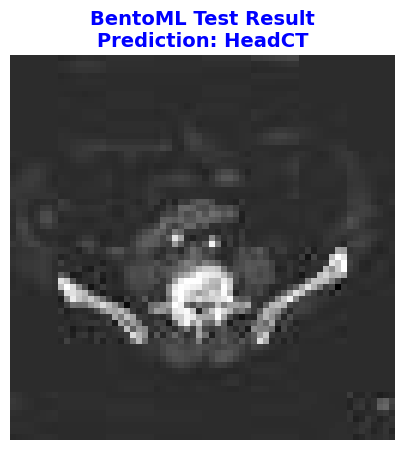

In [18]:
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np
from mednist_classifier_bentoml import MedNISTClassifier

# 1. 準備圖片
test_image_path = image_files[0][0] 
test_image = PIL.Image.open(test_image_path).convert("L")

# 2. 載入 BentoML 服務 (在記憶體中執行，不需要 Port)
bento_service = MedNISTClassifier()
bento_service.pack("classifier", net.cpu().eval())

# 3. 執行預測
with open(test_image_path, "rb") as f:
    prediction = bento_service.predict([f])

# 4. 畫圖 (報告要的證明)
plt.figure(figsize=(5, 5))
plt.imshow(np.array(test_image), cmap="gray")
plt.title(f"BentoML Test Result\nPrediction: {prediction[0]}", 
          fontsize=14, color="blue", fontweight="bold")
plt.axis("off")
plt.show()

## Cleanup data directory
Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)